In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [0]:
!pip install pycodestyle flake8 pycodestyle_magic
%load_ext pycodestyle_magic
clear_output()

In [0]:
!chmod 600 kaggle.json

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c kuzushiji-recognition
clear_output()

In [0]:
!mkdir train_images
!mkdir test_images

In [0]:
!unzip train_images.zip -d train_images
!unzip test_images.zip -d test_images
!unzip train.csv.zip
!rm train_images.zip
!rm test_images.zip
!rm train.csv.zip
clear_output()

#Data
Source: https://www.kaggle.com/c/kuzushiji-recognition/ <br>
Kuzushiji is an ancient Japanese cursive script. The goal is to locate and classify each kuzushiji character on each image in the test set. <br>
Train set size: 3881 images. <br>
Test set size: 4150 images. <br>
**train.csv** contains labels for each kuzushiji character in the train set. Train.csv columns:
*   **image_id** – ID code for the image.
*   **labels** – string with labels for all kuzushiji characters on the image, separated by space. Each label is a space-separated series of values (Unicode char, X, Y, width and height) of the character.

Predictions for the test set should have the following format:
*   **image_id**
*    **labels**, formatted like (Unicode char, X, Y). Width and height don't need to be predicted.

Predictions will be evaluated on F1-score. In this version of the metric, a correct (i. e., true positive) prediction is made when the character is correct and X and Y coordinates are within the ground truth bounding box. The ground truth bounding boxes are defined in the format {Unicode char X Y Width Height}, so if the ground truth label is U+003F 1 1 10 10 then a prediction of U+003F 3 3 would pass. <br>
Mapping between Japanese characters and corresponding Unicode IDs is stored in the file **unicode_translation.csv**. <br>
Notes about the data:
*   Some images don't contain kuzushiji characters.
*   Kuzushiji text is written such that annotations are placed between the columns of the main text, usually in a slightly smaller font. Annotation characters should be ignored.
*   You can occasionally see through especially thin paper and read characters from the opposite side of the page. Those characters should also be ignored.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
data = pd.read_csv("train.csv")

In [11]:
data.shape

(3881, 2)

In [12]:
# labels for the train set
data.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [0]:
unicode_translation = pd.read_csv("unicode_translation.csv")

In [14]:
unicode_translation.head(n=10)

,Unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9
5,U+003F,?
6,U+2000B,𠀋
7,U+20D45,𠵅
8,U+2123D,𡈽
9,U+22999,𢦙


In [0]:
# store mapping in dictionary
mapping = dict()
for i in range(len(unicode_translation.index)):
    mapping[unicode_translation["Unicode"][i]] = unicode_translation["char"][i]

In [0]:
sample_submission = pd.read_csv("sample_submission.csv")

In [0]:
# a sample submission in the correct format
sample_submission.head()

In [0]:
# removing rows contains NaN
data = data.dropna()
data.shape

In [0]:
# for evaluation of different models, let's split
# our data into 0.75 and 0.25 train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data["image_id"], data["labels"])

#Visualizing data
Source: https://www.kaggle.com/anokas/kuzushiji-visualisation <br>
A function below prints an image with labels and bounding boxes for all recognized on that image characters.



In [0]:
from os import listdir
from PIL import Image, ImageDraw, ImageFont

In [0]:
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

In [0]:
fontsize = 50
font = ImageFont.truetype("./NotoSansCJKjp-Regular.otf",
                          fontsize, encoding="utf-8")
clear_output()

In [0]:
def visualize_training_data(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)

    # Read image
    imsource = Image.open(image_fn).convert("RGBA")
    bbox_canvas = Image.new("RGBA", imsource.size)
    char_canvas = Image.new("RGBA", imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    # Separate canvases for boxes and chars
    # so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        char = mapping[codepoint]
        # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h),
                            fill=(255, 255, 255, 0),
                            outline=(255, 0, 0, 255))
        char_draw.text((x + w + fontsize/4, y + h/2 - fontsize),
                       char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource,
                                                           bbox_canvas),
                                     char_canvas)
    imsource = imsource.convert("RGB")
    # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

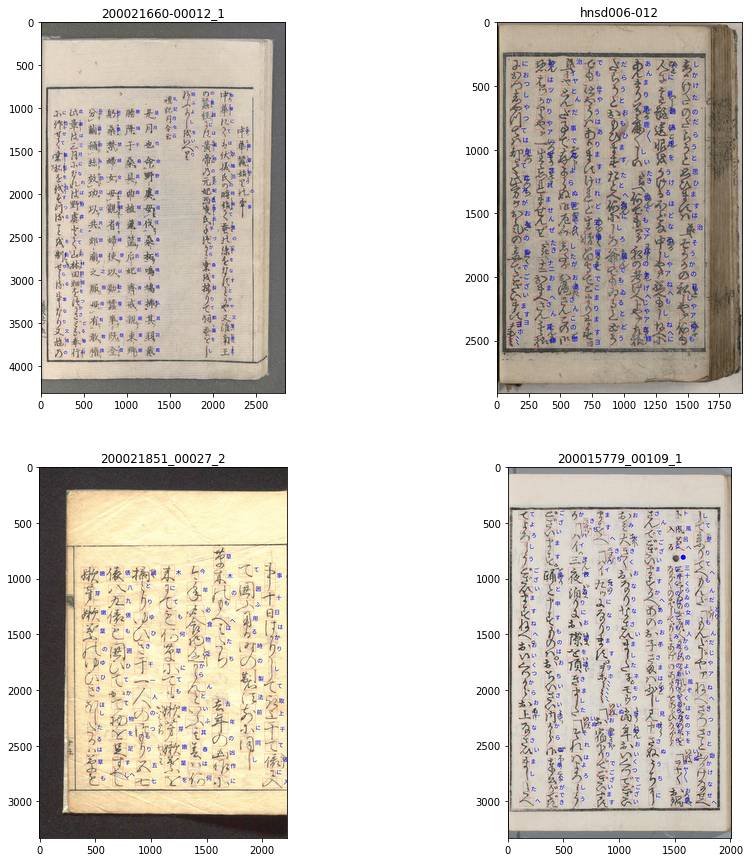

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i in range(2):
    for j in range(2):
        img, labels = data.values[np.random.randint(len(data))]
        viz = visualize_training_data(f"train_images/{img}.jpg", labels)
        ax[i, j].imshow(viz, interpolation="lanczos")
        ax[i, j].set_title(img)

plt.show()

A similar function, but for predictions. It prints only predicted labels, without bounding boxes.

In [0]:
def visualize_predictions(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 3)

    # Read image
    imsource = Image.open(image_fn).convert("RGBA")
    bbox_canvas = Image.new("RGBA", imsource.size)
    char_canvas = Image.new("RGBA", imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    # Separate canvases for boxes and chars
    # so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y in labels:
        x, y = int(x), int(y)
        char = mapping[codepoint]
        # Convert codepoint to actual unicode character

        # Draw bounding box around character,
        # and unicode character next to it
        bbox_draw.rectangle((x - 10, y - 10, x + 10, y + 10),
                            fill=(255, 0, 0, 255))
        char_draw.text((x + 25, y - fontsize * (3 / 4)),
                       char, fill=(255, 0, 0, 255), font=font)

    imsource = Image.alpha_composite(
        Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB")
    # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

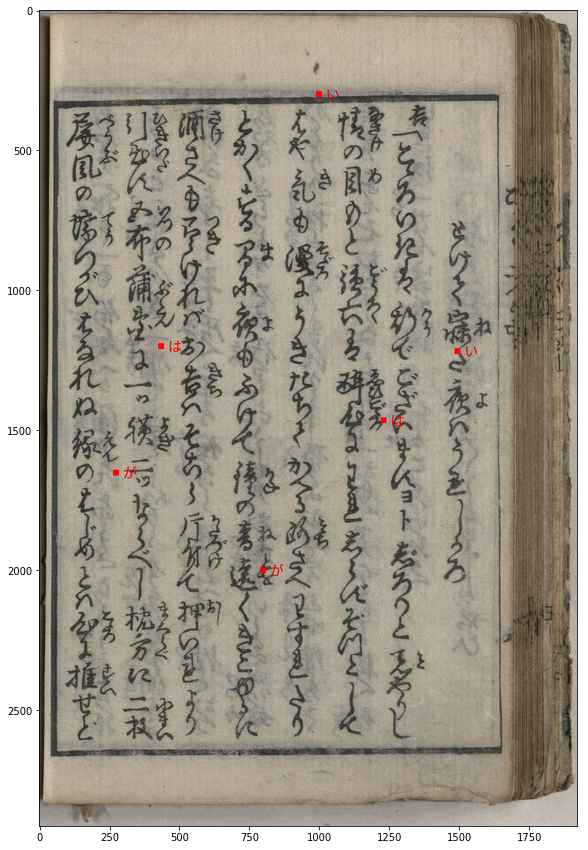

In [75]:
img = data.values[np.random.randint(len(data))][0]
# just some random prediction string
example_pred = "U+306F 1231 1465 U+304C 275 1652 U+3044 \
1495 1218 U+306F 436 1200 U+304C 800 2000 U+3044 1000 300"
viz = visualize_predictions(f"train_images/{img}.jpg", example_pred)
plt.figure(figsize=(15, 15))
plt.imshow(viz, interpolation="lanczos")
plt.show()

#Approach 1: Convolutional Neural Network